In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

import logging
from src.utils import setup_logging
setup_logging(console=True, file=False, debug=True)
logger = logging.getLogger(__name__)

[INFO]: Logging setup completed at 20-07-2024-132221        (utils.py:62 [13:22:21])


['The night will start off cold at -16.4°C and gradually drop to a freezing -18.8°C by midday. The temperature will slightly rise to -16.3°C in the afternoon before it drops back down to -18.5°C by midnight.', 'The night will be bitterly cold with temperatures around -5.1°C, but it will slightly warm up to -2.5°C in the afternoon before dropping to -3.4°C in the evening.', 'The night will start off cold with temperatures around -5.8°C, but it will get colder towards early morning, reaching down to -8.0°C. The day will be slightly warmer, with temperatures rising to -5.1°C in the late afternoon, but then dropping again to -8.0°C by midnight.', 'The night will start off cool with temperatures around 11 degrees Celsius and will gradually drop to a chilly 9.7 degrees by early morning. The day will slowly warm up, reaching a high of 12.1 degrees in the afternoon before cooling off to around 9.4 degrees by midnight.', 'The night will start off chilly with temperatures around 3.9°C, decreasin

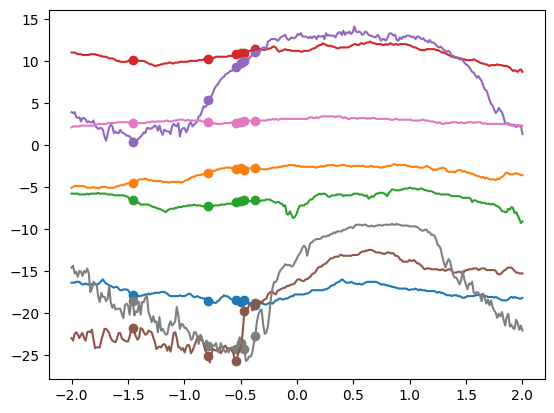

In [2]:
import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt
# Load the data
data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data_test = TempData(data=data, max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

batch = data_test.generate_batch(batch_size=8, return_knowledge=True)

print(batch.knowledge)
for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy())
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context.numpy(), y_context.numpy())
plt.show()

In [9]:
from src.plot import plot_predictive
from src.informed_np import InformedNeuralProcess
from tqdm import tqdm
# from src.loss import ELBOLoss
from src.loss import ELBOLoss

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f'Using DEVICE: {DEVICE}')

data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data = TempData(data=data , max_num_context=10, device=DEVICE)

USE_KNOWLEDGE = True
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

model = InformedNeuralProcess(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    determ_dim=determ_dim,
    knowledge_dim=128,
    mlps_activation=nn.GELU(),
    x_proj_dim=1,
    n_h_layers_x_proj=0,
    n_h_layers_decoder=4,
    n_h_layers_latent_xy_encoder=3,
    n_h_layers_film_latent_encoder=3,
    path='latent',
    train_num_z_samples=4,
    test_num_z_samples=32,
    use_bias=True,
    user_context_in_target=True, # TODO investigate
    use_latent_self_attn=True,
    # use_determ_self_attn=True,
    # use_determ_cross_attn=True,
    use_knowledge=USE_KNOWLEDGE,
    knowledge_dropout=0.3,
    roberta_return_cls=True,
    tune_llm_layer_norms=True,
    freeze_llm=True,
    knowledge_projection_n_h_layers=0,
    knowledge_aggregation_method='FiLM+MLP',
    device='cuda',
    beta=1.0
).to(DEVICE)

logging.info(model)
logging.info(f'Number of model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
logging.info(f'Using optimiser Adam')
loss_function = ELBOLoss(beta=1, reduction='mean')

[INFO]: Using DEVICE: cuda:0        (2842003532.py:8 [16:29:33])
[INFO]: USE_KNOWLEDGE: True        (2842003532.py:15 [16:29:34])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:29:34])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:29:34])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:29:34])
[DEBUG]: Starting new HTTPS connection (1): huggingface.co:443        (connectionpool.py:1051 [16:29:34])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [16:29:34])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [16:29:34])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task 

  0%|          | 0/10000 [00:00<?, ?it/s]

iter 1: Val Loss: 16560.93197631836


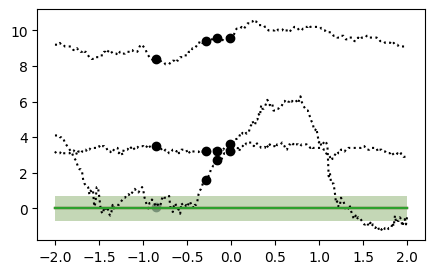

 10%|▉         | 997/10000 [03:01<24:29,  6.13it/s] 

iter 1001: Avg. Loss = 223839.7451791992
iter 1001: Val Loss: 1004.8631834983826


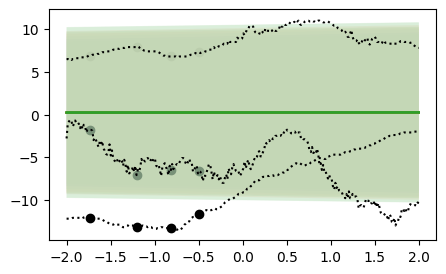

 11%|█         | 1088/10000 [03:33<29:06,  5.10it/s]  


KeyboardInterrupt: 

In [10]:
train_losses = []
old_losses = []
AVG_LOSS_PRINT_INTERVAL = 1000
PLOT_SAMPLE_INTERVAL = 1000

MAX_ITERS = 10000

for iter in tqdm(range(MAX_ITERS)):
    model.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=64, device=DEVICE, return_knowledge=USE_KNOWLEDGE)
    p_y_pred, q_z_context, q_z_target = model(batch.x_context, batch.y_context, batch.x_target, batch.y_target, batch.knowledge)

    loss_dict = loss_function(p_y_pred, q_z_context, q_z_target, batch.y_target)

    # old_loss, _ = calculate_loss(p_y_pred, batch.y_target, q_z_target, q_z_context)
    # old_losses.append(old_loss.item())
    
    train_loss = loss_dict["loss"]
    train_loss.backward()
    optimiser.step() 

    train_losses.append(train_loss.item())

    if iter % AVG_LOSS_PRINT_INTERVAL == 0:
        if iter > 0:
            print(f"iter {iter+1}: Avg. Loss = {sum(train_losses[-AVG_LOSS_PRINT_INTERVAL:])/AVG_LOSS_PRINT_INTERVAL}")
        # print(f"iter {iter+1}: Avg. Loss = {sum(old_losses[-1000:])/1000}")

        with torch.no_grad():
            val_loss = 0
            n_val_batches = 128
            val_batch_size = 96
            for _ in range(n_val_batches):
                batch = data.generate_batch(batch_size=64, device=DEVICE, return_knowledge=USE_KNOWLEDGE, training=False)
                model.training = False
                p_y_pred, q_z_context, q_z_target = model(batch.x_context, batch.y_context, batch.x_target, batch.y_target, batch.knowledge)
                loss_dict = loss_function(p_y_pred, q_z_context, None, batch.y_target)
                val_loss += loss_dict["loss"].item()
            print(f"iter {iter+1}: Val Loss: {val_loss / n_val_batches}")
        model.training = True
        
    if iter % PLOT_SAMPLE_INTERVAL == 0:
        model.training = False
        batch = data.generate_batch(batch_size=3, device=DEVICE, return_knowledge=USE_KNOWLEDGE, training=False)
        plot_predictive(model, batch, save=False, iter=None)
        model.training = True

# plt.plot(train_loss, label='train_loss')
# window = 50
# plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
# plt.legend()
# plt.show()

In [77]:
with torch.no_grad():
    val_loss = 0
    n_val_batches = 128
    val_batch_size = 96
    for _ in range(n_val_batches):
        batch = data.generate_batch(batch_size=val_batch_size, training=False, device=model.device)
        model.training = False
        p_y_pred, q_z_context, q_z_target = model(batch.x_context, batch.y_context, batch.x_target, None, batch.y_target)
        loss_dict = loss_function((p_y_pred, q_z_context, None), batch.y_target)
        val_loss += loss_dict[0].item()
    print(f"iter {iter+1}: Val Loss: {val_loss / n_val_batches}")
model.training = True

iter 17171: Val Loss: 854.8170294761658


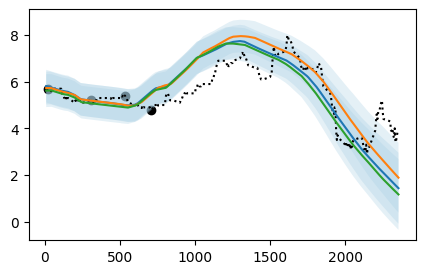

In [28]:
model.training = False
batch = data.generate_batch(batch_size=1, training=False, device=model.device)
plot_predictive(model, batch, knowledge=None, save=False, iter=None)
model.training = True


In [16]:
import transformers
from transformers import RobertaModel, RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
langmodel = RobertaModel.from_pretrained("roberta-base")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
langmodel.to(device)
# freeze everything
for name, param in langmodel.named_parameters():
    if "LayerNorm" in name or name == 'pooler.dense.bias' or name == 'pooler.dense.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False

#verify
for name, param in langmodel.named_parameters():
    print(name,param.requires_grad)

[DEBUG]: Starting new HTTPS connection (1): huggingface.co:443  ([2024-07-19 08:54:44] connectionpool.py:1051)
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/tokenizer_config.json HTTP/11" 200 0  ([2024-07-19 08:54:44] connectionpool.py:546)
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0  ([2024-07-19 08:54:44] connectionpool.py:546)
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0  ([2024-07-19 08:54:44] connectionpool.py:546)


KeyboardInterrupt: 

NeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): GELU(approximate='none')
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): GELU(approximate='none')
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): GELU(approximate='none')
        (8): Linear(in_features=128, out_features=128, bias=True)
        (9): GELU(approximate='none')
        (10): Linear(in_features=128, out_features=128, bias=True)
        (11): Identity()
      )
    )
    (rho): Linear(in_features=128, out_features=128, bias=True)
    (cross_attention_block): CrossAttention(
      (q_proj): Linear(in_features=128, out_features=128, bias=True)
      (k_proj): Linear(in_features=128, out_features=128, bias=True)
      (v_proj): Lin

  0%|          | 0/100001 [00:00<?, ?it/s]

iter 1: Avg. Loss SLOW = 23.9564296875
Val Loss: 16363.0146484375


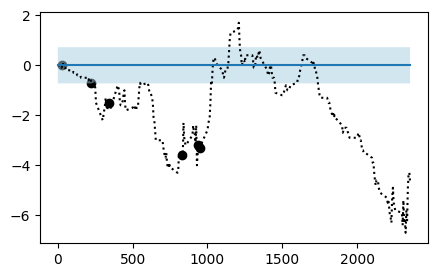

  1%|          | 984/100001 [02:21<3:51:53,  7.12it/s]

iter 1001: Avg. Loss = 1371.3650053710937


  2%|▏         | 1979/100001 [04:42<3:49:56,  7.10it/s]

iter 2001: Avg. Loss = 825.6592733154297


  3%|▎         | 2987/100001 [07:03<3:45:45,  7.16it/s]

iter 3001: Avg. Loss = 609.216155670166


  4%|▍         | 3995/100001 [09:24<3:43:55,  7.15it/s]

iter 4001: Avg. Loss = 572.6883545837402


  5%|▌         | 5002/100001 [11:45<3:42:38,  7.11it/s]

iter 5001: Avg. Loss = 559.4265250244141


  6%|▌         | 5938/100001 [13:57<3:40:23,  7.11it/s]

iter 6001: Avg. Loss = 548.3296486206054


  7%|▋         | 6948/100001 [16:18<3:37:01,  7.15it/s]

iter 7001: Avg. Loss = 549.4437937316894


  8%|▊         | 7956/100001 [18:40<3:34:40,  7.15it/s]

iter 8001: Avg. Loss = 547.3991734008789


  9%|▉         | 8964/100001 [21:01<3:33:03,  7.12it/s]

iter 9001: Avg. Loss = 538.3132267150879


 10%|▉         | 9972/100001 [23:22<3:29:51,  7.15it/s]

iter 10001: Avg. Loss = 542.1308537597656
iter 10001: Avg. Loss SLOW = 6640.015580505371
Val Loss: 539.7378540039062


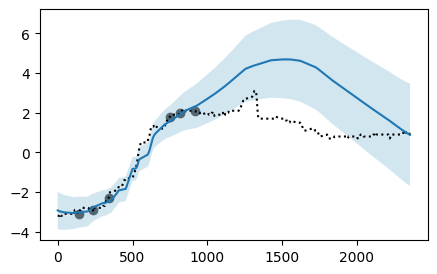

 11%|█         | 10979/100001 [25:46<3:29:05,  7.10it/s]

iter 11001: Avg. Loss = 543.0914686279297


 12%|█▏        | 11988/100001 [28:08<3:24:44,  7.16it/s]

iter 12001: Avg. Loss = 532.3450851135254


 13%|█▎        | 12999/100001 [30:29<3:23:06,  7.14it/s]

iter 13001: Avg. Loss = 534.1593942871094


 14%|█▍        | 13935/100001 [32:40<3:21:00,  7.14it/s]

iter 14001: Avg. Loss = 525.9138946838378


 15%|█▍        | 14943/100001 [35:01<3:18:32,  7.14it/s]

iter 15001: Avg. Loss = 528.0674024963379


 16%|█▌        | 15947/100001 [37:23<3:18:53,  7.04it/s]

iter 16001: Avg. Loss = 528.7950945739747


 17%|█▋        | 16968/100001 [39:45<3:12:22,  7.19it/s]

iter 17001: Avg. Loss = 528.6839168395996


 18%|█▊        | 17985/100001 [42:06<3:11:05,  7.15it/s]

iter 18001: Avg. Loss = 530.6639389648437


 19%|█▉        | 18933/100001 [44:18<3:07:13,  7.22it/s]

iter 19001: Avg. Loss = 526.5544255371094


 20%|█▉        | 19955/100001 [46:40<3:04:59,  7.21it/s]

iter 20001: Avg. Loss = 523.6991371459961
iter 20001: Avg. Loss SLOW = 5301.973758270264
Val Loss: 532.4949951171875


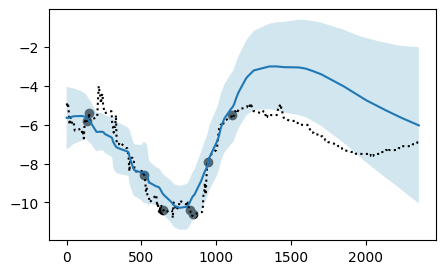

 21%|██        | 20974/100001 [49:03<3:02:10,  7.23it/s]

iter 21001: Avg. Loss = 515.9198327026368


 22%|██▏       | 21996/100001 [51:24<2:59:39,  7.24it/s]

iter 22001: Avg. Loss = 525.856572845459


 23%|██▎       | 22945/100001 [53:36<2:57:50,  7.22it/s]

iter 23001: Avg. Loss = 515.4177964172363


 24%|██▍       | 23966/100001 [55:57<2:55:40,  7.21it/s]

iter 24001: Avg. Loss = 510.3230696411133


 25%|██▍       | 24988/100001 [58:18<2:52:50,  7.23it/s]

iter 25001: Avg. Loss = 510.39477786254884


 26%|██▌       | 25937/100001 [1:00:30<2:51:02,  7.22it/s]

iter 26001: Avg. Loss = 508.5371583251953


 27%|██▋       | 26958/100001 [1:02:51<2:48:29,  7.23it/s]

iter 27001: Avg. Loss = 503.0642421264648


 29%|██▉       | 28997/100001 [1:07:34<2:43:36,  7.23it/s]

iter 29001: Avg. Loss = 499.06072512817383


 30%|██▉       | 29946/100001 [1:09:45<2:41:27,  7.23it/s]

iter 30001: Avg. Loss = 500.54304544067384
iter 30001: Avg. Loss SLOW = 5087.755708679199
Val Loss: 526.810791015625


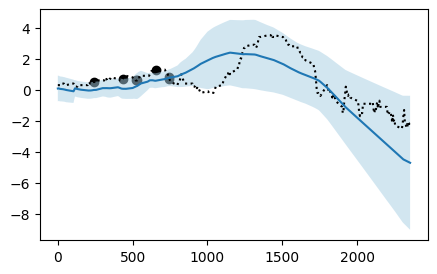

 31%|███       | 30966/100001 [1:12:09<2:39:44,  7.20it/s]

iter 31001: Avg. Loss = 512.9031107788086


 32%|███▏      | 31986/100001 [1:14:31<2:37:06,  7.22it/s]

iter 32001: Avg. Loss = 501.54896551513673


 33%|███▎      | 32932/100001 [1:16:42<2:35:23,  7.19it/s]

iter 33001: Avg. Loss = 499.6855223693848


 34%|███▍      | 33952/100001 [1:19:04<2:32:47,  7.20it/s]

iter 34001: Avg. Loss = 497.04228982543947


 35%|███▍      | 34974/100001 [1:21:26<2:30:07,  7.22it/s]

iter 35001: Avg. Loss = 495.59085443115237


 36%|███▌      | 35995/100001 [1:23:47<2:27:50,  7.22it/s]

iter 36001: Avg. Loss = 487.19154080200195


 37%|███▋      | 36943/100001 [1:25:59<2:25:39,  7.22it/s]

iter 37001: Avg. Loss = 487.8066882629395


 38%|███▊      | 37955/100001 [1:28:20<2:24:34,  7.15it/s]

iter 38001: Avg. Loss = 492.50317535400393


 39%|███▉      | 38977/100001 [1:30:42<2:21:03,  7.21it/s]

iter 39001: Avg. Loss = 491.9586025085449


 40%|███▉      | 39997/100001 [1:33:03<2:18:45,  7.21it/s]

iter 40001: Avg. Loss = 485.4801080932617
iter 40001: Avg. Loss SLOW = 4951.710857940674
Val Loss: 550.7266845703125


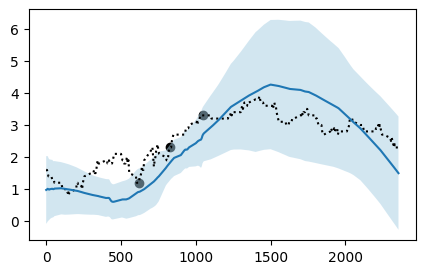

 41%|████      | 40946/100001 [1:35:17<2:16:15,  7.22it/s]

iter 41001: Avg. Loss = 481.238854888916


 42%|████▏     | 41968/100001 [1:37:39<2:13:49,  7.23it/s]

iter 42001: Avg. Loss = 481.3686446533203


 43%|████▎     | 42990/100001 [1:40:00<2:11:20,  7.23it/s]

iter 43001: Avg. Loss = 481.2689278564453


 44%|████▍     | 43939/100001 [1:42:11<2:09:09,  7.23it/s]

iter 44001: Avg. Loss = 476.26943173217774


 45%|████▍     | 44959/100001 [1:44:32<2:06:42,  7.24it/s]

iter 45001: Avg. Loss = 478.30228985595704


 46%|████▌     | 45980/100001 [1:46:54<2:04:31,  7.23it/s]

iter 46001: Avg. Loss = 485.5301823730469


 47%|████▋     | 47002/100001 [1:49:15<2:02:14,  7.23it/s]

iter 47001: Avg. Loss = 485.8365174560547


 48%|████▊     | 47951/100001 [1:51:26<1:59:53,  7.24it/s]

iter 48001: Avg. Loss = 548.2967840576172


 49%|████▉     | 48973/100001 [1:53:48<1:58:09,  7.20it/s]

iter 49001: Avg. Loss = 557.021600769043


 50%|████▉     | 49992/100001 [1:56:09<1:55:37,  7.21it/s]

iter 50001: Avg. Loss = 558.165262512207
iter 50001: Avg. Loss SLOW = 5033.298496154785
Val Loss: 583.62353515625


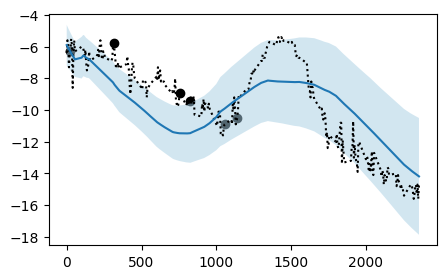

 51%|█████     | 50941/100001 [1:58:24<1:53:25,  7.21it/s]

iter 51001: Avg. Loss = 513.3809118041992


 52%|█████▏    | 51958/100001 [2:00:45<1:51:20,  7.19it/s]

iter 52001: Avg. Loss = 504.6460089416504


 53%|█████▎    | 52977/100001 [2:03:06<1:48:41,  7.21it/s]

iter 53001: Avg. Loss = 491.550724029541


 54%|█████▍    | 53995/100001 [2:05:28<1:46:41,  7.19it/s]

iter 54001: Avg. Loss = 494.000272857666


 55%|█████▍    | 54934/100001 [2:07:38<1:44:28,  7.19it/s]

iter 55001: Avg. Loss = 487.53985223388673


 56%|█████▌    | 55942/100001 [2:10:00<1:43:47,  7.07it/s]

iter 56001: Avg. Loss = 486.95400485229493


 57%|█████▋    | 56949/100001 [2:12:21<1:40:20,  7.15it/s]

iter 57001: Avg. Loss = 482.0995071716309


 58%|█████▊    | 57962/100001 [2:14:42<1:38:10,  7.14it/s]

iter 58001: Avg. Loss = 483.27919619750975


 59%|█████▉    | 58970/100001 [2:17:03<1:35:35,  7.15it/s]

iter 59001: Avg. Loss = 484.91028677368166


 60%|█████▉    | 59980/100001 [2:19:24<1:33:12,  7.16it/s]

iter 60001: Avg. Loss = 483.7532645874023
iter 60001: Avg. Loss SLOW = 4912.114029449463
Val Loss: 607.7719116210938


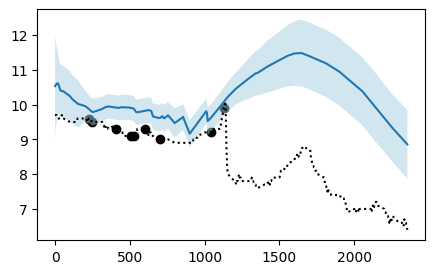

 61%|██████    | 60993/100001 [2:21:48<1:30:35,  7.18it/s]

iter 61001: Avg. Loss = 482.2519457092285


 62%|██████▏   | 61931/100001 [2:23:59<1:28:39,  7.16it/s]

iter 62001: Avg. Loss = 479.22636532592776


 63%|██████▎   | 62949/100001 [2:26:21<1:25:43,  7.20it/s]

iter 63001: Avg. Loss = 483.8192778015137


 64%|██████▍   | 63964/100001 [2:28:42<1:23:36,  7.18it/s]

iter 64001: Avg. Loss = 474.9933201599121


 65%|██████▍   | 64970/100001 [2:31:03<1:23:22,  7.00it/s]

iter 65001: Avg. Loss = 477.8750107421875


 66%|██████▌   | 65982/100001 [2:33:25<1:19:08,  7.16it/s]

iter 66001: Avg. Loss = 473.89068518066404


 67%|██████▋   | 67000/100001 [2:35:46<1:16:32,  7.19it/s]

iter 67001: Avg. Loss = 475.0987686767578


 68%|██████▊   | 67945/100001 [2:37:57<1:13:58,  7.22it/s]

iter 68001: Avg. Loss = 472.8535310668945


 69%|██████▉   | 68966/100001 [2:40:19<1:11:41,  7.21it/s]

iter 69001: Avg. Loss = 467.91316943359374


 70%|██████▉   | 69988/100001 [2:42:41<1:09:27,  7.20it/s]

iter 70001: Avg. Loss = 470.51551168823244
iter 70001: Avg. Loss SLOW = 4758.437585784912
Val Loss: 540.6129150390625


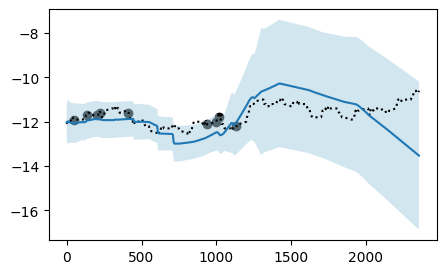

 71%|███████   | 71002/100001 [2:45:04<1:07:00,  7.21it/s]

iter 71001: Avg. Loss = 470.40968722534177


 72%|███████▏  | 71950/100001 [2:47:15<1:04:58,  7.20it/s]

iter 72001: Avg. Loss = 473.87423455810546


 73%|███████▎  | 72960/100001 [2:49:36<1:02:57,  7.16it/s]

iter 73001: Avg. Loss = 470.0021811523437


 74%|███████▍  | 73971/100001 [2:51:57<1:00:18,  7.19it/s]

iter 74001: Avg. Loss = 466.7216307373047


 75%|███████▍  | 74984/100001 [2:54:18<57:58,  7.19it/s]  

iter 75001: Avg. Loss = 468.0330242614746


 76%|███████▌  | 75999/100001 [2:56:39<55:33,  7.20it/s]

iter 76001: Avg. Loss = 473.33743280029296


 77%|███████▋  | 76942/100001 [2:58:50<53:39,  7.16it/s]

iter 77001: Avg. Loss = 470.5101130065918


 78%|███████▊  | 77952/100001 [3:01:11<51:10,  7.18it/s]

iter 78001: Avg. Loss = 468.7044523925781


 79%|███████▉  | 78965/100001 [3:03:32<48:48,  7.18it/s]

iter 79001: Avg. Loss = 461.74700442504883


 80%|███████▉  | 79973/100001 [3:05:53<46:46,  7.14it/s]

iter 80001: Avg. Loss = 468.2334920043945
iter 80001: Avg. Loss SLOW = 4691.573252563477
Val Loss: 536.5985717773438


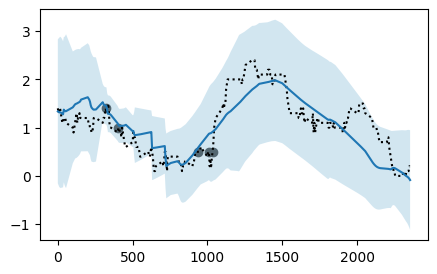

 81%|████████  | 80991/100001 [3:08:17<44:02,  7.19it/s]

iter 81001: Avg. Loss = 469.763079498291


 82%|████████▏ | 81939/100001 [3:10:29<41:46,  7.21it/s]

iter 82001: Avg. Loss = 468.07367901611326


 83%|████████▎ | 82952/100001 [3:12:50<39:41,  7.16it/s]

iter 83001: Avg. Loss = 460.41709146118166


 84%|████████▍ | 83965/100001 [3:15:11<37:15,  7.17it/s]

iter 84001: Avg. Loss = 461.5391283569336


 85%|████████▍ | 84979/100001 [3:17:33<34:45,  7.20it/s]

iter 85001: Avg. Loss = 463.2252283935547


 86%|████████▌ | 86000/100001 [3:19:54<32:31,  7.18it/s]

iter 86001: Avg. Loss = 459.400683013916


 87%|████████▋ | 86947/100001 [3:22:05<30:05,  7.23it/s]

iter 87001: Avg. Loss = 458.2623641052246


 88%|████████▊ | 87968/100001 [3:24:27<27:50,  7.20it/s]

iter 88001: Avg. Loss = 458.81936056518555


 89%|████████▉ | 88990/100001 [3:26:49<25:25,  7.22it/s]

iter 89001: Avg. Loss = 454.3959769592285


 90%|████████▉ | 89939/100001 [3:29:00<23:13,  7.22it/s]

iter 90001: Avg. Loss = 459.143133605957
iter 90001: Avg. Loss SLOW = 4613.039724975586
Val Loss: 576.7901000976562


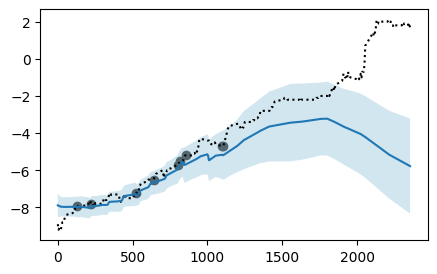

 91%|█████████ | 90956/100001 [3:31:24<20:56,  7.20it/s]

iter 91001: Avg. Loss = 465.2961449584961


 92%|█████████▏| 91971/100001 [3:33:45<18:33,  7.21it/s]

iter 92001: Avg. Loss = 461.93221728515624


 93%|█████████▎| 92991/100001 [3:36:06<16:13,  7.20it/s]

iter 93001: Avg. Loss = 458.30853015136717


 94%|█████████▍| 93931/100001 [3:38:17<14:06,  7.17it/s]

iter 94001: Avg. Loss = 460.73588708496095


 95%|█████████▍| 94944/100001 [3:40:38<11:43,  7.19it/s]

iter 95001: Avg. Loss = 454.50996127319337


 96%|█████████▌| 95959/100001 [3:43:00<09:23,  7.18it/s]

iter 96001: Avg. Loss = 448.89369677734373


 97%|█████████▋| 96979/100001 [3:45:21<06:59,  7.21it/s]

iter 97001: Avg. Loss = 458.3916351623535


 98%|█████████▊| 97993/100001 [3:47:42<04:39,  7.19it/s]

iter 98001: Avg. Loss = 457.97456723022464


 99%|█████████▉| 98934/100001 [3:49:53<02:28,  7.18it/s]

iter 99001: Avg. Loss = 457.12769848632814


100%|█████████▉| 99956/100001 [3:52:15<00:06,  7.21it/s]

iter 100001: Avg. Loss = 475.8789781188965
iter 100001: Avg. Loss SLOW = 4599.049316528321
Val Loss: 606.09228515625


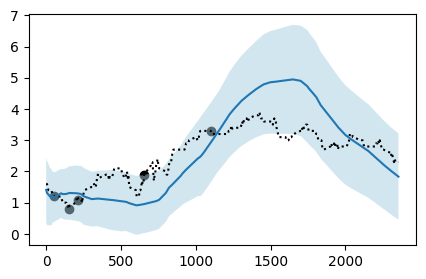

100%|██████████| 100001/100001 [3:52:24<00:00,  7.17it/s]


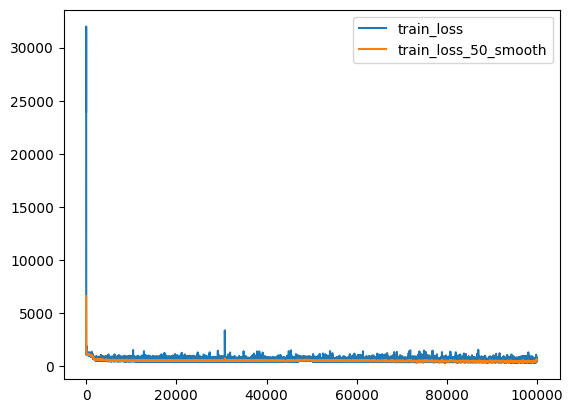

In [66]:
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

# np = NeuralProcess(x_dim=x_dim,
#                    y_dim=y_dim,
#                    hidden_dim=hidden_dim,
#                    latent_dim=latent_dim,
#                    determ_dim=determ_dim,
#                    knowledge_dim=768,
#                    n_h_layers_decoder=3,
#                    n_h_layers_phi_latent_encoder=2,
#                    n_h_layers_rho_latent_encoder=1,
#                    n_h_layers_phi_determ_encoder=6,
#                    n_h_layers_rho_determ_encoder=0,
#                    use_deterministic_path=False,
#                    )

model = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=4,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=5,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=True,
                   use_latent_self_attn=True,
                   use_determ_self_attn=False,
                   use_determ_cross_attn=True,
                   use_knowledge=True,
                   use_linear_knowledge_encoder=True,
                   knowledge_aggregation_method='FiLM+MLP',
                   knowledge_dim=768
                   )
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(model.parameters(), lr=5e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
model.to(device)

def preprocess_knowledge(knowledge_pre, langmodel, tokenizer):
    tokens = tokenizer.batch_encode_plus(
                        list(knowledge_pre),
                        add_special_tokens=True,
                        max_length=110,
                        padding='max_length',
                        return_token_type_ids=True
                    )
    input_ids = torch.tensor(tokens['input_ids']).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).to(device)
    token_type_ids = torch.tensor(tokens['token_type_ids']).to(device)
    lang_output = langmodel(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    knowledge_post = lang_output.pooler_output.unsqueeze(1)
    return knowledge_post

data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data = TempData(data=data , max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in tqdm(range(100000+1), mininterval=10):
    model.training = True
    optimiser.zero_grad()

    batch, knowledge_pre = data.generate_batch(batch_size=64, device=device, return_knowledge=True)
    # print(knowledge)
    knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)

    zero_prob = 0.3
    mask = torch.rand((64, 1, 1), device=device) > 0.3
    knowledge = knowledge * mask
    # print(knowledge)
    # break
    
    p_y_pred, loss, log_lik = model(batch.x_context, batch.y_context, batch.x_target, knowledge, batch.y_target)
    # print(loss.item())
    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()

    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0
    if iter % 10000 == 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0
        
        with torch.no_grad():
            val_loss = 0
            n_val_batches = 32
            val_batch_size = 64
            for _ in range(n_val_batches):
                batch, knowledge_pre = data.generate_batch(batch_size=val_batch_size, training=False, device=model.device, return_knowledge=True)
                knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)
                
                p_y_pred, _loss, log_lik = model(batch.x_context, batch.y_context, batch.x_target, knowledge, batch.y_target)
                val_loss += _loss
            print(f"Val Loss: {val_loss / n_val_batches}")
        
    # if iter % 20000 == 0:
        model.training = False
        batch, knowledge_pre = data.generate_batch(batch_size=1, device=model.device, training=False, return_knowledge=True)
        knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)
        plot_predictive(model, batch, knowledge=knowledge, save=False, iter=None)
        model.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
# torch.save(np.state_dict(), f'../exp/{"inp_roberta_test1.pt"}')
model.load_state_dict(torch.load(f'../exp/{"inp_roberta_test1.pt"}'))

<All keys matched successfully>

In [52]:
model.training = False
batch, knowledge_pre = data.generate_batch(batch_size=1, device=model.device, return_knowledge=True)
print(knowledge_pre)

['The night will start off cold with temperatures falling to -5.3°C by early morning, but it will gradually warm up reaching 6.2°C in the late afternoon, before cooling down again to -2.0°C at midnight.']


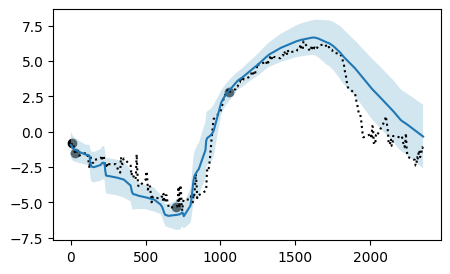

In [56]:
# knowledge_pre = ['The night will be bitterly cold with temperatures falling to -16.4°C, gradually rising to -13.4°C by early morning, and remarkably, the afternoon will see a significant temperature shift, hovering around freezing point at 0.3°C.']
knowledge_pre = ['The night will start off cold with temperatures falling to -5.3°C by early morning, but it will gradually warm up reaching 20°C in the late afternoon, before cooling down again to -2.0°C at midnight.']

model.training = False
knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)
plot_predictive(model, batch, knowledge=knowledge, save=False, iter=None)

model.training = True
